# Figure 6: Investigating root cause of G1 discrepancies: Kernel density estimation of the per-class packet size distributions.

[:simple-jupyter: :material-download:](../../paper_tables_and_figures/figure6_ucdavis_kde_on_pkts_size/figure6_ucdavis_kde_on_pkts_size.ipynb)

In [1]:
import itertools

import numpy as np
import pandas as pd

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import tcbench as tcb
from tcbench import dataprep

In [4]:
FLOWPIC_DIM = 32
FLOWPIC_BLOCK_DURATION = 15

In [5]:
# load unfiltered dataset
dset = dataprep.FlowpicDataset(
    data=tcb.load_parquet(tcb.DATASETS.UCDAVISICDM19),
    timetofirst_colname="timetofirst",
    pkts_size_colname="pkts_size",
    pkts_dir_colname="pkts_dir",
    target_colname="app",
    flowpic_dim=FLOWPIC_DIM,
    flowpic_block_duration=FLOWPIC_BLOCK_DURATION,
)

In [8]:
TARGETS_LABEL = sorted(dset.df["app"].unique())
PARTITIONS_NAME = sorted(dset.df["partition"].unique())

TARGETS_LABEL, PARTITIONS_NAME

(['google-doc', 'google-drive', 'google-music', 'google-search', 'youtube'],
 ['pretraining', 'retraining-human-triggered', 'retraining-script-triggered'])

In [12]:
all_pkts_size = dict()

for partition_name in PARTITIONS_NAME:
    all_pkts_size[partition_name] = dict()

    for app in TARGETS_LABEL:
        df_tmp = dset.df[
            (dset.df["partition"] == partition_name) & (dset.df["app"] == app)
        ]

        l = []
        for idx in df_tmp.index:
            ser = df_tmp.loc[idx]
            indexes = np.where(ser["timetofirst"] < FLOWPIC_BLOCK_DURATION)[0]
            pkts_size = ser["pkts_size"][indexes]
            l.append(pkts_size)
        all_pkts_size[partition_name][app] = np.concatenate(l)

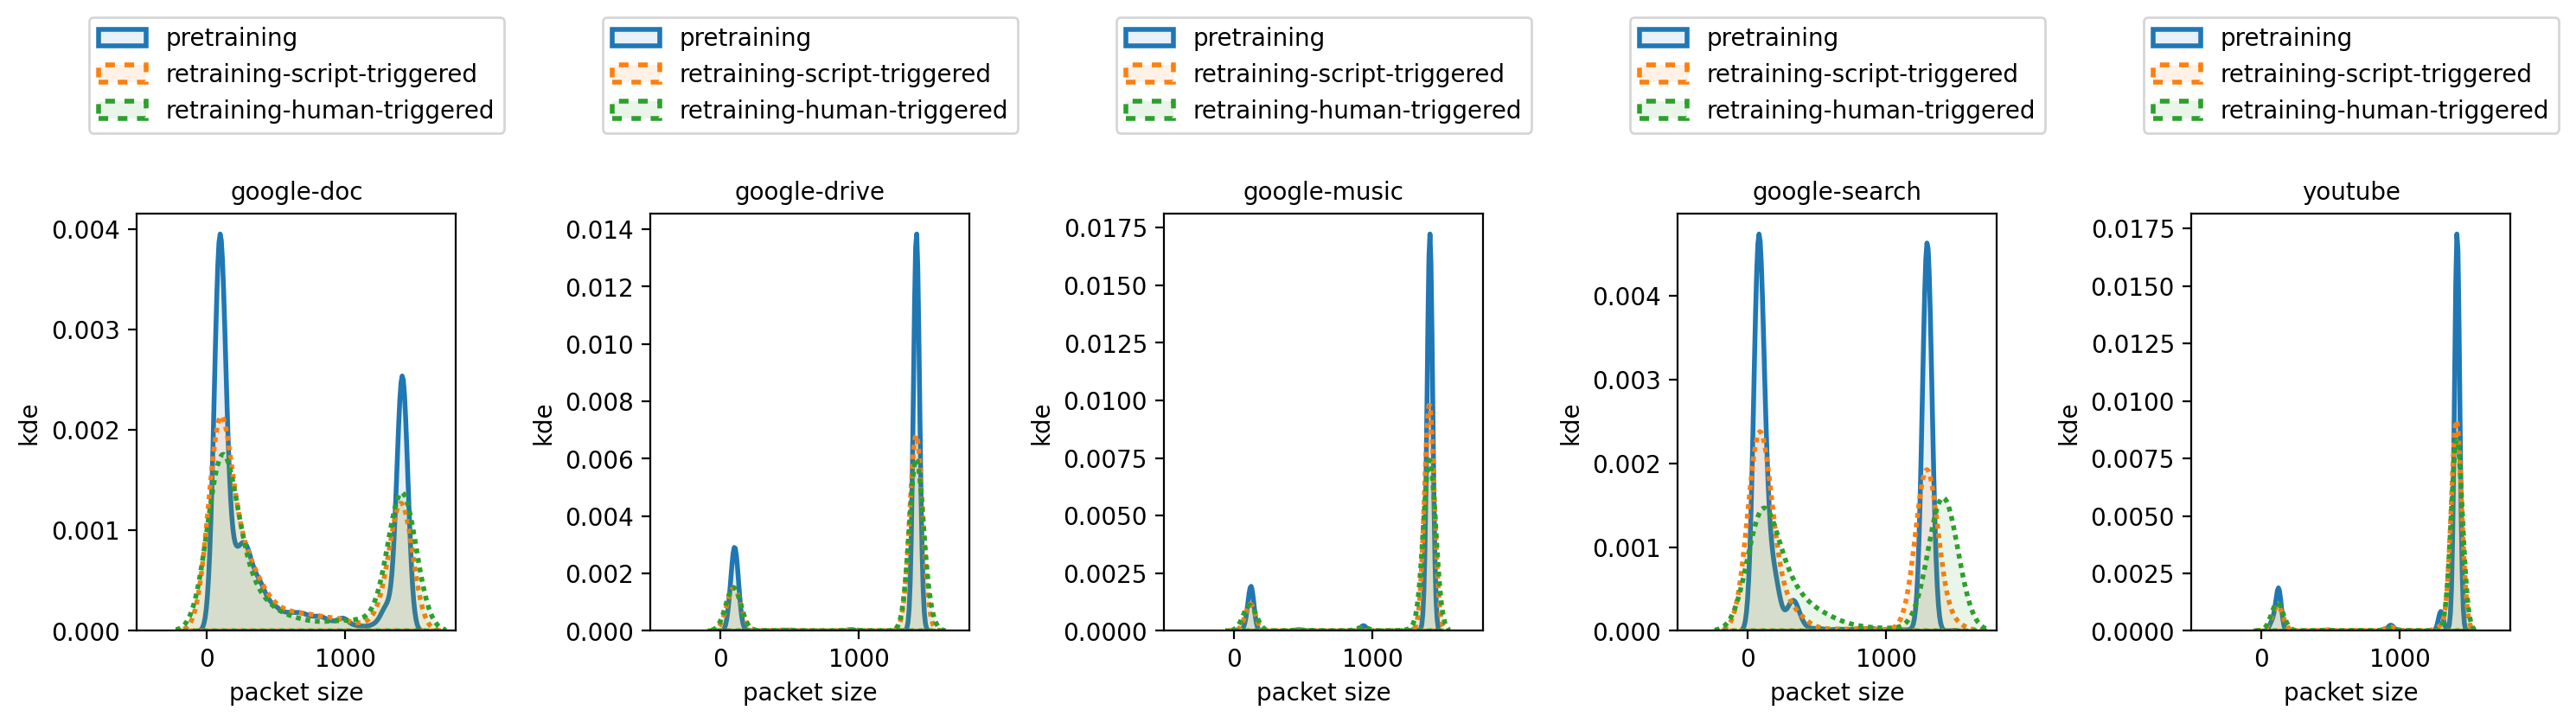

In [13]:
# WARNING: computing the KDE will take a few minutes

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

line_props = {
    "pretraining": dict(linestyle="-"),
    "retraining-script-triggered": dict(
        linestyle=(0, (1, 1))
    ), 
    "retraining-human-triggered": dict(linestyle=(0, (1, 1))),
}

for ax, app in zip(axes, TARGETS_LABEL):
    for partition_name in [
        "pretraining",
        "retraining-script-triggered",
        "retraining-human-triggered",
    ]:
        props = line_props[partition_name]
        sns.kdeplot(
            ax=ax,
            data=all_pkts_size[partition_name][app],
            linewidth=2,
            label=partition_name,
            **props,
            fill=True,
            alpha=0.1
        )
    ax.legend(bbox_to_anchor=(0.5, 1.5), loc="upper center")
    ax.set_title(app, fontsize=10)
    ax.set_xlim((-500, 1800))
    ax.set_xlabel("packet size")
    ax.set_ylabel("kde")

plt.tight_layout()